# Plateforme Agnostique de Traitement et d'Analyse des Textes
### Carnet d'expérimentation
---

## Sujet : CamemBERT Embeddings on PyTorch  Logistic Regression


---

# Initialisations
---

In [1]:
_rs = 42

In [2]:
cd ../..

/Volumes/Geek/Work/Patat


In [3]:
import ast
import importlib
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm
tqdm.pandas()

# Préparation Données

---

## Chargement

In [4]:
import patat.util.file

filename = 'data/prod/230517-OIDS-Label.pickle'

df_label = patat.util.file.pickle_load(filename)

## Labels ou textes Nuls

In [5]:
df_label['text'].isna().sum()

0

In [6]:
df_label['infox'].isna().sum()

4

In [7]:
df_label = df_label[df_label['infox'].notna()]

In [8]:
df_label.reset_index(inplace=True)

## Données dupliquées

In [9]:
df_label.duplicated(subset='text').sum()

0

In [10]:
df_label.duplicated(subset='url').sum()

0

# Experience
---

## Equilibrage Dataset

<Axes: xlabel='infox', ylabel='count'>

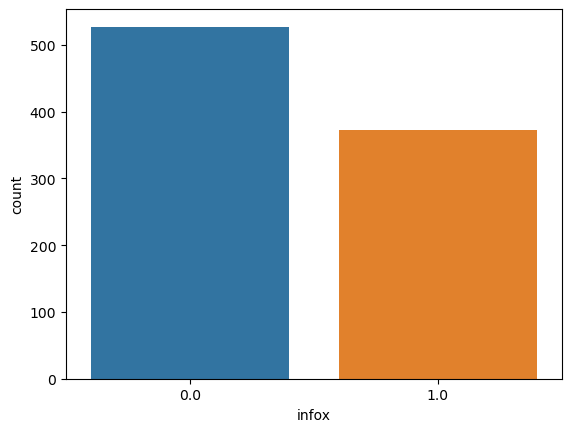

In [11]:
label_count = df_label['infox'].value_counts()
sns.barplot(x=label_count.index, y=label_count)

In [12]:
df_0 = df_label[df_label['infox'] == 0]
df_1 = df_label[df_label['infox'] == 1]

min_sample = min(len(df_0),len(df_1))


df_0=df_0.sample(min_sample,random_state=_rs)
df_1=df_1.sample(min_sample,random_state=_rs)
df_ml = pd.concat([df_0,df_1])

df_ml

,index,url,site,title,article,tags,paragraphs,date_iso,abstract,Auteur,...,inversion_preuve,denigrement,degre_infox,observateur,source,p_count,text,c_count,p_size,url_h
609,610,https://www.francesoir.fr/politique-france/gue...,www.francesoir.fr,Guerre en Ukraine: Emmanuel Macron prévient le...,À l’occasion de la cérémonie pour le 78e anniv...,"[Accueil, Politique]",[À l’occasion de la cérémonie pour le 78e anni...,2022-08-20T00:00:00,,,...,0.0,0.0,,CN,Recueil,11,Guerre en Ukraine: Emmanuel Macron prévient le...,2629,239.000000,857bfacdd98e36dda26f1f92cf40c992904d6386
705,708,https://www.profession-gendarme.com/la-vaccina...,www.profession-gendarme.com,La vaccination Covid : un marquage de « type b...,De: Dr R Date: 16 avril 2022 à 08:17:22 ﻿bonjo...,"[Actualités, Tribune]",[De: Dr R Date: 16 avril 2022 à 08:17:22 ﻿bonj...,,,NaN,...,NaN,NaN,NaN,NaN,Test1,17,La vaccination Covid : un marquage de « type b...,6252,367.764706,166d32300f4d7766a82fe39a1185f35bc347c05f
26,26,https://www.mondialisation.ca/colonialisme-ene...,www.mondialisation.ca,Colonialisme énergétique,Visite d’État du président de la République it...,"[Moyen-Orient et Afrique du Nord, Guerre USA O...",[Visite d’État du président de la République i...,2022-07-09T00:00:00,,Pangea Grandangolo,...,0.0,NaN,,GP,Recueil,8,Colonialisme énergétique\nVisite d’État du pré...,2794,349.250000,2a39a60fd5e2c6df0f6ec8ce9fedc2ee2eb4ab4d
565,566,https://www.francesoir.fr/opinions-editos/de-l...,www.francesoir.fr,De l’importance d’une Assemblée vraiment natio...,"Depuis hier soir, ne serions-nous pas en train...","[Accueil, Opinions]","[Depuis hier soir, ne serions-nous pas en trai...",2022-06-20T19:46:00,,Xavier Azalbert,...,0.0,NaN,,GP,Recueil,16,De l’importance d’une Assemblée vraiment natio...,4582,286.375000,93b25370fea82c7039f7e2b00c0bd73151101af3
231,232,https://www.polemia.com/quelle-politique-migra...,www.polemia.com,Quelle politique migratoire pour la France ? –...,"Par André-Victor Robert, haut fonctionnaire ♦ ...","[Accueil, Géopolitique, Afrique, analyse, Andr...","[Facebook, Twitter, LinkedIn, Print Friendly, ...",,"Par André-Victor Robert, haut fonctionnaire ♦ ...",André Victor Robert,...,0.0,0.0,,FB,Recueil,31,Quelle politique migratoire pour la France ? –...,9123,294.290323,c12a81bb99810b5c13fba93abc5f9cea077a873d
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112,112,https://lesdeqodeurs.fr/des-scientifiques-de-h...,lesdeqodeurs.fr,Des scientifiques de Harvard et de Johns Hopki...,Article original datant du 31/08/22 par SSRNCO...,"[ARNm, COVID, effets secondaires, étude, Harva...",[Les étudiants des universités nord-américaine...,2022-09-23T00:00:00,,,...,0.0,0.0,1,FB,Recueil,5,Des scientifiques de Harvard et de Johns Hopki...,1803,360.600000,1f56ed5fa54de7c492154ac8ee0d8d10724f1aa4
157,158,https://www.voltairenet.org/article217546.html,www.voltairenet.org,L’armée russe achète des exemplaires d’armemen...,L’achat de deux canons automoteurs CAESAR fran...,[],[L’achat de deux canons automoteurs CAESAR fra...,1900-01-01T00:00:00,,,...,1.0,NaN,1,FB,Recueil,3,L’armée russe achète des exemplaires d’armemen...,718,239.333333,b3153ba0ad9e32c02a8d49c99a6748e0764b20b5
522,523,https://lemediaen442.fr/onu-le-premier-ministr...,lemediaen442.fr,ONU – Le Premier ministre de Nouvelle-Zélande ...,L’argument principal de la ministre est que le...,"[Politique, Vidéos, censure, jacinda ardern, ONU]",[L’argument principal de la ministre est que l...,2022-09-29T09:56:31+02:00,"Le terrible discours de Jacinda Ardern, Premie...",,...,0.0,0.0,1,FB,Recueil,7,ONU – Le Premier ministre de Nouvelle-Zélande ...,2420,345.714286,3d47a59ef99274fd9ee96c209cc2ab41d6e1f6bb
847,853,https://fr.sott.net/article/36258-Pandemie-ou-...,fr.sott.net,Pandémie ou le retour du grand Pan,"Au cours des deux dernières décennies, les pub...",[La Science de l'Esprit],"[Au cours des deux dernières décennies, les pu...",,,NaN,...,NaN,NaN,NaN,NaN,Verif,59,Pandémie ou le retour du 

## Embeddings

In [13]:
import torch
device = 'mps' if torch.backends.mps.is_available() else 'cpu'
print(f'device : {device}')

from transformers import AutoTokenizer, AutoModel

tokenizer = AutoTokenizer.from_pretrained('camembert-base')
model = AutoModel.from_pretrained('camembert-base').to(device)

device : mps


Some weights of the model checkpoint at camembert-base were not used when initializing CamembertModel: ['lm_head.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight']
- This IS expected if you are initializing CamembertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing CamembertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [14]:
## function to generate BERT embeddings
def get_embeddings(text):
    input_ids = tokenizer.encode(text,add_special_tokens=True,return_tensors='pt').to(device)
    input_ids = input_ids[:,:512]
    with torch.inference_mode():
        last_hidden_state = model(input_ids)[0].to(device)
        embeddings = torch.mean(last_hidden_state,dim=1).squeeze().to(device)
        
    return embeddings.cpu().numpy()

In [15]:
%%time
import numpy as np
## Generate embeddings for the text data using BERT
embeddings = np.array([get_embeddings(text) for text in tqdm(df_ml['text'])])
labels = df_ml['infox']

  0%|          | 0/746 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (605 > 512). Running this sequence through the model will result in indexing errors


CPU times: user 37.7 s, sys: 4.37 s, total: 42.1 s
Wall time: 43 s


# PyTorch Logistic Regression

In [16]:
import numpy as np
import torch
import torch.nn as nn

### 0. Prepare data

In [17]:
device = 'mps' if torch.backends.mps.is_available else 'cpu'
device

'mps'

In [18]:
X = embeddings
y = df_ml['infox']

In [19]:
from sklearn.model_selection import train_test_split

n_samples, n_features = X.shape

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=_rs)

In [20]:
X_train = torch.from_numpy(X_train.astype(np.float32))
X_test = torch.from_numpy(X_test.astype(np.float32))
y_train = torch.from_numpy(y_train.values.astype(np.float32))
y_test = torch.from_numpy(y_test.values.astype(np.float32))

y_train = y_train.view(y_train.shape[0], 1)
y_test = y_test.view(y_test.shape[0], 1)

### 1. Model

In [21]:
# Linear model f = wx + b , sigmoid at the end
class LRModel(nn.Module):
    
    _nb_hidden = 3
    
    def __init__(self, n_input_features):
        super(LRModel, self).__init__()
#        self.linear = nn.Linear(n_input_features, 1)
        self.linear = nn.Linear(n_input_features, self._nb_hidden)
        self.relu = nn.ReLU(self._nb_hidden)
        self.hidden = nn.Linear(self._nb_hidden, 1)

    def forward(self, x):
        y_pred = self.linear(x)
        y_pred = self.relu(y_pred)
        y_pred = self.hidden(y_pred)
        y_pred = torch.sigmoid(y_pred)
        return y_pred

model = LRModel(n_features)
model.to(device)

LRModel(
  (linear): Linear(in_features=768, out_features=3, bias=True)
  (relu): ReLU(inplace=True)
  (hidden): Linear(in_features=3, out_features=1, bias=True)
)

### 2. Loss and optimizer

In [22]:
num_epochs = 10000
learning_rate = 0.02
criterion = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

### 3. Training loop - MPS

In [23]:
from sklearn import metrics

In [24]:
X_train=X_train.to(device)
X_test=X_test.to(device)
y_train=y_train.to(device)
y_test=y_test.to(device)

In [25]:
%%time
scores=[]
for epoch in tqdm(range(num_epochs)):
    # Forward pass and loss
    y_pred = model(X_train)
    loss = criterion(y_pred, y_train)

    # Backward pass and update
    loss.backward()
    optimizer.step()

    # zero grad before new step
    optimizer.zero_grad()

    if (epoch+1) % 500 == 0:
        with torch.no_grad():
            y_predicted = model(X_test)
            y_predicted_cls = y_predicted.round()
            pred = y_predicted.to('cpu').T.numpy().round()[0]
            proba = y_predicted.to('cpu').T.numpy()[0]
            true = y_test.to('cpu').T.numpy()[0]

            accuracy = metrics.accuracy_score(true,pred)
            f1 = metrics.f1_score(true,pred)
            recall = metrics.recall_score(true,pred)
            roc_auc = metrics.roc_auc_score(true,proba)
            scores.append({
                'epoch': epoch+1,
                'loss': float(loss),
                'accuracy': accuracy,
                'f1': f1,
                'recall': recall,
                'roc_auc': roc_auc,
            })

  0%|          | 0/10000 [00:00<?, ?it/s]

CPU times: user 8.44 s, sys: 396 ms, total: 8.84 s
Wall time: 8.43 s


### Metriques

<Axes: xlabel='epoch'>

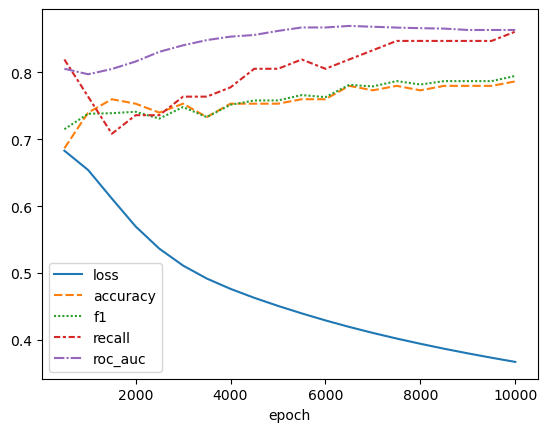

In [26]:
df_scores = pd.DataFrame(scores).set_index('epoch')
sns.lineplot(df_scores)

In [27]:
pd.set_option('display.precision',3)
df_scores

,loss,accuracy,f1,recall,roc_auc
epoch,,,,,
500,0.683,0.687,0.715,0.819,0.806
1000,0.654,0.740,0.738,0.764,0.797
1500,0.611,0.760,0.739,0.708,0.805
2000,0.570,0.753,0.741,0.736,0.816
2500,0.536,0.740,0.731,0.736,0.831
3000,0.511,0.753,0.748,0.764,0.841
3500,0.492,0.733,0.733,0.764,0.848
4000,0.476,0.753,0.752,0.778,0.854
4500,0.463,0.753,0.758,0.806,0.856


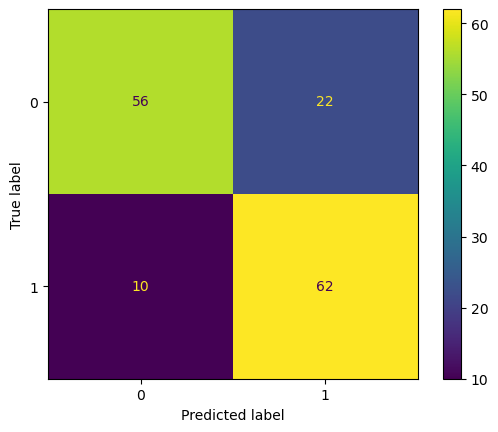

In [28]:
cm = metrics.confusion_matrix(true, pred)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

## Sklearn Logistic Regression

In [29]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

In [82]:
%%time
classifier = LogisticRegression(C=15, random_state=_rs, solver='lbfgs', multi_class='ovr', max_iter=1000)
scores = cross_validate(classifier, embeddings, labels, cv=5,scoring=('balanced_accuracy','f1_weighted','recall','precision','roc_auc'))
df_scores=pd.DataFrame(scores)
df_scores.mean()

ValueError: 'balanced_f1' is not a valid scoring value. Use sklearn.metrics.get_scorer_names() to get valid options.

In [84]:
metrics.get_scorer_names()

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'matthews_corrcoef',
 'max_error',
 'mutual_info_score',
 'neg_brier_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_absolute_percentage_error',
 'neg_mean_gamma_deviance',
 'neg_mean_poisson_deviance',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'neg_negative_likelihood_ratio',
 'neg_root_mean_squared_error',
 'normalized_mutual_info_score',
 'positive_likelihood_ratio',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'rand_score',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',

In [75]:
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.metrics import roc_curve, balanced_accuracy_score, accuracy_score

In [61]:
X_train, X_test, y_train, y_test = train_test_split(embeddings, labels, test_size=0.2, random_state=42)

In [63]:
classifier.fit(X_train,y_train)

LogisticRegression(C=15, max_iter=1000, multi_class='ovr', random_state=42)

In [66]:
fpr, tpr, thresholds = roc_curve(y_train,classifier.predict_proba(X_train)[:,1],drop_intermediate=False)

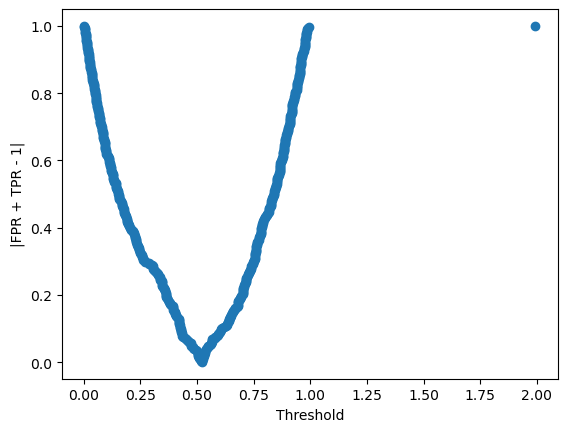

In [67]:
import matplotlib.pyplot as plt
plt.scatter(thresholds,np.abs(fpr+tpr-1))
plt.xlabel("Threshold")
plt.ylabel("|FPR + TPR - 1|")
plt.show()

In [68]:
thresholds[np.argmin(np.abs(fpr+tpr-1))]

0.5221597618873945

In [77]:
threshold = []
accuracy = []

for p in np.unique(classifier.predict_proba(X_train)[:,1]):
    threshold.append(p)
    y_pred = (classifier.predict_proba(X_train)[:,1] >= p).astype(int)
    accuracy.append(accuracy_score(y_train,y_pred))

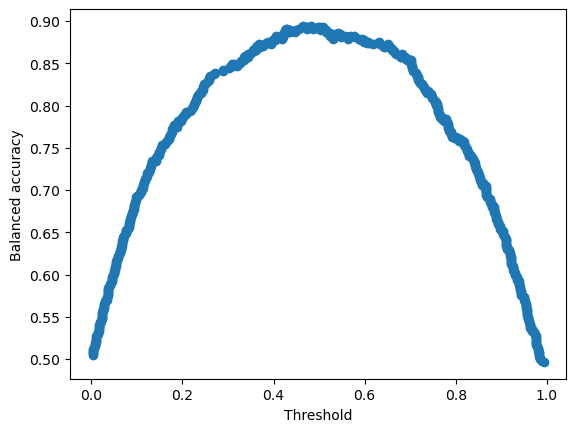

In [78]:
plt.scatter(threshold,accuracy)
plt.xlabel("Threshold")
plt.ylabel("Balanced accuracy")
plt.show()

In [79]:
threshold[np.argmax(accuracy)]

0.4649981085581543

# Conclusions
---